# Sprint 1: Schema Design and Prototyping

#### Initial configuration and conection to duckdb

In [1]:
import duckdb
import pandas as pd
import os
import glob

# --- Configuration ---
# Define paths to your raw data and the future lakehouse layers
RAW_DATA_PATH = '../data/raw'
LAKEHOUSE_PATH = '../data/lakehouse'
LAKEHOUSE_DB_PATH = os.path.join(LAKEHOUSE_PATH, 'lakehouse.duckdb')

# Create the lakehouse directories if they don't exist
os.makedirs(os.path.join(LAKEHOUSE_PATH, 'bronze'), exist_ok=True)
os.makedirs(os.path.join(LAKEHOUSE_PATH, 'silver'), exist_ok=True)
os.makedirs(os.path.join(LAKEHOUSE_PATH, 'gold'), exist_ok=True)

# --- DuckDB Connection ---
con = duckdb.connect(database=LAKEHOUSE_DB_PATH, read_only=False)

print(f"DuckDB is now connected to the persistent database file at:")
print(f"-> {LAKEHOUSE_DB_PATH}")

DuckDB is now connected to the persistent database file at:
-> ../data/lakehouse\lakehouse.duckdb


---

#### Step 1: Data Exploration


## 1. Data Exploration: Inspecting the Raw Files

#### Explore a MITMA Mobility File

In [2]:
# Path to one of the daily mobility files
mobility_file_path = os.path.join(RAW_DATA_PATH, 'mitma', '20230508_Viajes_distritos.csv.gz')

# Use DuckDB to directly read and describe the gzipped CSV
# The 'read_csv_auto' function is powerful and can infer types, headers, etc.
query = f"""--sql
    SELECT *
    FROM read_csv_auto('{mobility_file_path}')
    LIMIT 5;
"""
df_mobility_sample = con.execute(query).df()

print("--- Sample of Mobility Data ---")
display(df_mobility_sample)

print("\n--- Schema of Mobility Data ---")
# Let's get the column names and data types as inferred by DuckDB
query_desc = f"DESCRIBE SELECT * FROM read_csv_auto('{mobility_file_path}');"
df_mobility_schema = con.execute(query_desc).df()
display(df_mobility_schema)

--- Sample of Mobility Data ---


,fecha,periodo,origen,destino,distancia,actividad_origen,actividad_destino,estudio_origen_posible,estudio_destino_posible,residencia,renta,edad,sexo,viajes,viajes_km
0,20230508,03,01009_AM,01001,0.5-2,frecuente,casa,no,False,01,<10,NA,NA,2.521,2.703
1,20230508,18,01009_AM,01001,0.5-2,frecuente,casa,no,False,01,<10,NA,NA,6.162,7.997
2,20230508,19,01009_AM,01001,0.5-2,frecuente,casa,no,False,01,<10,NA,NA,6.162,6.208
3,20230508,20,01009_AM,01001,0.5-2,frecuente,casa,no,False,01,<10,NA,NA,9.030,11.528
4,20230508,07,01009_AM,01001,10-50,frecuente,casa,no,False,01,<10,NA,NA,2.685,30.125



--- Schema of Mobility Data ---


,column_name,column_type,null,key,default,extra
0,fecha,BIGINT,YES,None,None,None
1,periodo,VARCHAR,YES,None,None,None
2,origen,VARCHAR,YES,None,None,None
3,destino,VARCHAR,YES,None,None,None
4,distancia,VARCHAR,YES,None,None,None
5,actividad_origen,VARCHAR,YES,None,None,None
6,actividad_destino,VARCHAR,YES,None,None,None
7,estudio_origen_posible,VARCHAR,YES,None,None,None
8,estudio_destino_posible,BOOLEAN,YES,None,None,None
9,residencia,VARCHAR,YES,None,None,None


#### Explore the MITMA Zoning File

In [3]:
# Path to the district names file
zoning_file_path = os.path.join(RAW_DATA_PATH, 'mitma', 'nombres_distritos.csv')

# Load and inspect the zoning file
query = f"""--sql
    SELECT *
    FROM read_csv_auto('{zoning_file_path}')
    LIMIT 5;
"""
df_zoning_sample = con.execute(query).df()

print("--- Sample of Zoning Data ---")
display(df_zoning_sample)

print("\n--- Schema of Zoning Data ---")
query_desc = f"DESCRIBE SELECT * FROM read_csv_auto('{zoning_file_path}');"
df_zoning_schema = con.execute(query_desc).df()
display(df_zoning_schema)

--- Sample of Zoning Data ---


,ID,name
0,01001,Alegría-Dulantzi
1,01002,Amurrio
2,01004_AM,Artziniega agregacion de municipios
3,01009_AM,Asparrena agregacion de municipios
4,01010,Ayala/Aiara



--- Schema of Zoning Data ---


,column_name,column_type,null,key,default,extra
0,ID,VARCHAR,YES,None,None,None
1,name,VARCHAR,YES,None,None,None


#### Explore the INE Economic File

In [4]:
# Path to the INE GDP file
ine_file_path = os.path.join(RAW_DATA_PATH, 'ine', 'ine_renta_distritos.csv') # Or whatever you named it

# This file is semicolon-separated, so we tell DuckDB explicitly
query = f"""--sql
    SELECT *
    FROM read_csv_auto('{ine_file_path}', sep=';')
    LIMIT 5;
"""
df_ine_sample = con.execute(query).df()

print("--- Sample of INE Economic Data ---")
display(df_ine_sample)

--- Sample of INE Economic Data ---


,Municipios,Distritos,Secciones,Indicadores de renta media,Periodo,Total
0,01001 Alegría-Dulantzi,None,None,Renta neta media por persona,2023,16.429
1,01001 Alegría-Dulantzi,None,None,Renta neta media por persona,2022,15.116
2,01001 Alegría-Dulantzi,None,None,Renta neta media por persona,2021,14.647
3,01001 Alegría-Dulantzi,None,None,Renta neta media por persona,2020,13.969
4,01001 Alegría-Dulantzi,None,None,Renta neta media por persona,2019,14.299


---

#### Step 2: Data Ingestion

---
### 2.1 Bronze ingestion

#### 2.1.1 Mobility files

In [5]:

# --- 1. Define File Paths ---
# Source: All gzipped CSV files for the week in the raw/mitma directory
mitma_raw_glob_path = os.path.join(RAW_DATA_PATH, 'mitma', '*_Viajes_distritos.csv.gz')
# Destination: A single Parquet file in the bronze layer
bronze_mobility_path = os.path.join(LAKEHOUSE_PATH, 'bronze', 'mobility_sample_week.parquet')

# --- 2. Find all the raw mobility files ---
mobility_files = glob.glob(mitma_raw_glob_path)
# It's good practice to print the files you've found to ensure it's working
print("Found the following mobility files to ingest:")
for f in mobility_files:
    print(f" - {os.path.basename(f)}")

# --- 3. Construct and Execute the Ingestion Query ---
# The query reads all CSVs at once, adds metadata, and copies the result to a Parquet file.
# DuckDB's read_csv_auto can take a list of files.
# We also use 'filename=true' to automatically add a column with the source filename.
ingestion_query = f"""--sql
    COPY (
        SELECT 
            *,
            CURRENT_TIMESTAMP AS ingestion_timestamp
        FROM read_csv_auto({mobility_files}, filename=true, all_varchar=true) -- <--- THIS IS THE FIX
    ) TO '{bronze_mobility_path}' (FORMAT PARQUET, OVERWRITE_OR_IGNORE 1);
"""

# Execute the query
con.execute(ingestion_query)

print(f"\n✅ Successfully ingested {len(mobility_files)} files into a single Bronze Parquet file:")
print(f"   -> {bronze_mobility_path}")

Found the following mobility files to ingest:
 - 20230508_Viajes_distritos.csv.gz
 - 20230509_Viajes_distritos.csv.gz
 - 20230510_Viajes_distritos.csv.gz
 - 20230511_Viajes_distritos.csv.gz
 - 20230512_Viajes_distritos.csv.gz
 - 20230513_Viajes_distritos.csv.gz
 - 20230514_Viajes_distritos.csv.gz

✅ Successfully ingested 7 files into a single Bronze Parquet file:
   -> ../data/lakehouse\bronze\mobility_sample_week.parquet


In [6]:
# --- 4. Verification ---
# Let's read back from the new Parquet file to verify it was created correctly.
print("\n--- Verifying the Bronze Data ---")
verification_query = f"SELECT * FROM '{bronze_mobility_path}' LIMIT 5;"
bronze_sample_df = con.execute(verification_query).df()
display(bronze_sample_df)

print("\n--- Verifying the Bronze Schema ---")
schema_query = f"DESCRIBE FROM '{bronze_mobility_path}';"
bronze_schema_df = con.execute(schema_query).df()
display(bronze_schema_df)


--- Verifying the Bronze Data ---


,fecha,periodo,origen,destino,distancia,actividad_origen,actividad_destino,estudio_origen_posible,estudio_destino_posible,residencia,renta,edad,sexo,viajes,viajes_km,filename,ingestion_timestamp
0,20230508,03,01009_AM,01001,0.5-2,frecuente,casa,no,no,01,<10,NA,NA,2.521,2.703,../data/raw\\mitma\\20230508_Viajes_distritos....,2025-11-18 15:36:38.584554+01:00
1,20230508,18,01009_AM,01001,0.5-2,frecuente,casa,no,no,01,<10,NA,NA,6.162,7.997,../data/raw\\mitma\\20230508_Viajes_distritos....,2025-11-18 15:36:38.584554+01:00
2,20230508,19,01009_AM,01001,0.5-2,frecuente,casa,no,no,01,<10,NA,NA,6.162,6.208,../data/raw\\mitma\\20230508_Viajes_distritos....,2025-11-18 15:36:38.584554+01:00
3,20230508,20,01009_AM,01001,0.5-2,frecuente,casa,no,no,01,<10,NA,NA,9.03,11.528,../data/raw\\mitma\\20230508_Viajes_distritos....,2025-11-18 15:36:38.584554+01:00
4,20230508,07,01009_AM,01001,10-50,frecuente,casa,no,no,01,<10,NA,NA,2.685,30.125,../data/raw\\mitma\\20230508_Viajes_distritos....,2025-11-18 15:36:38.584554+01:00



--- Verifying the Bronze Schema ---


,column_name,column_type,null,key,default,extra
0,fecha,VARCHAR,YES,None,None,None
1,periodo,VARCHAR,YES,None,None,None
2,origen,VARCHAR,YES,None,None,None
3,destino,VARCHAR,YES,None,None,None
4,distancia,VARCHAR,YES,None,None,None
5,actividad_origen,VARCHAR,YES,None,None,None
6,actividad_destino,VARCHAR,YES,None,None,None
7,estudio_origen_posible,VARCHAR,YES,None,None,None
8,estudio_destino_posible,VARCHAR,YES,None,None,None
9,residencia,VARCHAR,YES,None,None,None


### 2.1.2 Supporting MITMA and INE Data into Bronze

In [7]:
# --- Ingest nombres_distritos.csv ---
source_path = os.path.join(RAW_DATA_PATH, 'mitma', 'nombres_distritos.csv')
dest_path = os.path.join(LAKEHOUSE_PATH, 'bronze', 'zoning_districts.parquet')
query = f"COPY (SELECT * FROM read_csv_auto('{source_path}', all_varchar=true)) TO '{dest_path}' (FORMAT PARQUET, OVERWRITE_OR_IGNORE 1);"
con.execute(query)
print(f"✅ Ingested zoning names to: {dest_path}")

# --- Ingest poblacion_distritos.csv ---
source_path = os.path.join(RAW_DATA_PATH, 'mitma', 'poblacion_distritos.csv')
dest_path = os.path.join(LAKEHOUSE_PATH, 'bronze', 'population_districts.parquet')
query = f"COPY (SELECT * FROM read_csv_auto('{source_path}', all_varchar=true)) TO '{dest_path}' (FORMAT PARQUET, OVERWRITE_OR_IGNORE 1);"
con.execute(query)
print(f"✅ Ingested population data to: {dest_path}")

# --- Ingest relacion_ine_zonificacionMitma.csv ---
source_path = os.path.join(RAW_DATA_PATH, 'mitma', 'relacion_ine_zonificacionMitma.csv')
dest_path = os.path.join(LAKEHOUSE_PATH, 'bronze', 'mapping_ine_mitma.parquet')
query = f"COPY (SELECT * FROM read_csv_auto('{source_path}', all_varchar=true)) TO '{dest_path}' (FORMAT PARQUET, OVERWRITE_OR_IGNORE 1);"
con.execute(query)
print(f"✅ Ingested INE-MITMA mapping to: {dest_path}")

# --- Ingest INE GDP data --- (semicolon-separated)
source_path = os.path.join(RAW_DATA_PATH, 'ine', 'ine_renta_distritos.csv')
dest_path = os.path.join(LAKEHOUSE_PATH, 'bronze', 'ine_rent_districts.parquet')
query = f"COPY (SELECT * FROM read_csv_auto('{source_path}', all_varchar=true, sep=';')) TO '{dest_path}' (FORMAT PARQUET, OVERWRITE_OR_IGNORE 1);"
con.execute(query)
print(f"✅ Ingested INE GDP data to: {dest_path}")

✅ Ingested zoning names to: ../data/lakehouse\bronze\zoning_districts.parquet
✅ Ingested population data to: ../data/lakehouse\bronze\population_districts.parquet
✅ Ingested INE-MITMA mapping to: ../data/lakehouse\bronze\mapping_ine_mitma.parquet
✅ Ingested INE GDP data to: ../data/lakehouse\bronze\ine_rent_districts.parquet


In [8]:
# --- Ingest municipios_coordenadas.csv ---
source_path = os.path.join(RAW_DATA_PATH, 'ine', 'municipios_coordenadas.csv')
dest_path = os.path.join(LAKEHOUSE_PATH, 'bronze', 'municipal_coordinates.parquet')
 

query = f"COPY (SELECT * FROM read_csv_auto('{source_path}', all_varchar=true)) TO '{dest_path}' (FORMAT PARQUET, OVERWRITE_OR_IGNORE 1);"
con.execute(query)

print(f"✅ Ingested municipal coordinates to: {dest_path}")

✅ Ingested municipal coordinates to: ../data/lakehouse\bronze\municipal_coordinates.parquet


In [9]:
# ---  Verification ---
# Let's read back from the new Parquet file to verify it was created correctly.
print("\n--- Verifying the Bronze Data ---")
verification_query = f"SELECT * FROM '{dest_path}' LIMIT 5;"
bronze_sample_df = con.execute(verification_query).df()
display(bronze_sample_df)

print("\n--- Verifying the Bronze Schema ---")
schema_query = f"DESCRIBE FROM '{dest_path}';"
bronze_schema_df = con.execute(schema_query).df()
display(bronze_schema_df)


--- Verifying the Bronze Data ---


,COD_INE,ID_REL,COD_GEO,COD_PROV,PROVINCIA,NOMBRE_ACTUAL,POBLACION_MUNI,SUPERFICIE,PERIMETRO,COD_INE_CAPITAL,CAPITAL,POBLACION_CAPITAL,HOJA_MTN25_ETRS89,LONGITUD_ETRS89,LATITUD_ETRS89,ORIGENCOOR,ALTITUD,ORIGENALTITUD
0,01001000000,1010014,01010,01,Araba/Álava,Alegría-Dulantzi,2975,"1994,5872",35069,01001000101,Alegría-Dulantzi,2860,0113-3,"-2,51243731","42,83981158",Mapa,568,MDT
1,01002000000,1010029,01020,01,Araba/Álava,Amurrio,10313,"9629,68",65381,01002000201,Amurrio,9238,0086-4,"-3,00007326","43,05427776",Mapa,219,MDT
2,01003000000,1010035,01030,01,Araba/Álava,Aramaio,1409,"7308,96",42097,01003000601,Ibarra,758,0087-4,"-2,56540037","43,05119653",Mapa,333,MDT
3,01004000000,1010040,01040,01,Araba/Álava,Artziniega,1832,"2728,73",22886,01004000101,Artziniega,1697,0086-1,"-3,12791718","43,12084358",Mapa,210,MDT
4,01006000000,1010066,01060,01,Araba/Álava,Armiñón,232,"1297,27",24707,01006000101,Armiñón,113,0137-4,"-2,87183475","42,72326199",Mapa,467,MDT



--- Verifying the Bronze Schema ---


,column_name,column_type,null,key,default,extra
0,COD_INE,VARCHAR,YES,None,None,None
1,ID_REL,VARCHAR,YES,None,None,None
2,COD_GEO,VARCHAR,YES,None,None,None
3,COD_PROV,VARCHAR,YES,None,None,None
4,PROVINCIA,VARCHAR,YES,None,None,None
5,NOMBRE_ACTUAL,VARCHAR,YES,None,None,None
6,POBLACION_MUNI,VARCHAR,YES,None,None,None
7,SUPERFICIE,VARCHAR,YES,None,None,None
8,PERIMETRO,VARCHAR,YES,None,None,None
9,COD_INE_CAPITAL,VARCHAR,YES,None,None,None


In [10]:
import glob

# --- 1. Create the 'bronze' schema if it doesn't exist ---
# This command creates the "drawer" in our database.
print("--- Creating database schemas (if they don't exist) ---")
con.execute("CREATE SCHEMA IF NOT EXISTS bronze;")
print("  - Schema 'bronze' is ready.")

# --- 2. Find all the Parquet files ---
bronze_files = glob.glob(os.path.join(LAKEHOUSE_PATH, 'bronze', '*.parquet'))

# --- 3. Register the files as views INSIDE the new schema ---
print("\n--- Registering Bronze Parquet files as persistent VIEWS in DuckDB ---")
for file_path in bronze_files:
    # Sanitize the filename to create a valid view name
    view_name = os.path.basename(file_path).replace('.parquet', '')
    
    query = f"CREATE OR REPLACE VIEW bronze.{view_name} AS SELECT * FROM read_parquet('{file_path}');"
    con.execute(query)
    print(f"  - View 'bronze.{view_name}' created.")
    
print("\n✅ All Bronze files are now visible to external tools under the 'bronze' schema.")

--- Creating database schemas (if they don't exist) ---
  - Schema 'bronze' is ready.

--- Registering Bronze Parquet files as persistent VIEWS in DuckDB ---
  - View 'bronze.ine_rent_districts' created.
  - View 'bronze.mapping_ine_mitma' created.
  - View 'bronze.mobility_sample_week' created.
  - View 'bronze.municipal_coordinates' created.
  - View 'bronze.population_districts' created.
  - View 'bronze.zoning_districts' created.

✅ All Bronze files are now visible to external tools under the 'bronze' schema.


---
### 2.2 Silver layer

In [11]:
# --- Setup: Create the 'silver' schema ---
print("--- Creating 'silver' schema if it doesn't exist ---")
con.execute("CREATE SCHEMA IF NOT EXISTS silver;")
print("  - Schema 'silver' is ready.")

--- Creating 'silver' schema if it doesn't exist ---
  - Schema 'silver' is ready.


Cleaned version of mobility data

In [12]:
# Clean the mobility data
print("Cleaning mobility data...")

con.execute("""
-- Create cleaned version of mobility data
CREATE OR REPLACE VIEW silver.cleaned_mobility AS
SELECT
    -- Fix dates (convert 20230508 → 2023-05-08)
    CAST(
        SUBSTR(fecha, 1, 4) || '-' || 
        SUBSTR(fecha, 5, 2) || '-' || 
        SUBSTR(fecha, 7, 2) 
    AS DATE) as trip_date,
    
    -- Fix hour (ensure it's a number)
    CAST(periodo AS INTEGER) as hour,
    
    -- Clean zone IDs
    TRIM(CAST(origen AS VARCHAR)) as origin_zone_id,
    TRIM(CAST(destino AS VARCHAR)) as destination_zone_id,
    
    -- Clean distance (handle messy values)
     CASE
        WHEN TRY_CAST(viajes AS BIGINT) > 0 THEN
            TRY_CAST(viajes_km AS DOUBLE) / TRY_CAST(viajes AS BIGINT)
        ELSE 0 -- If there are no trips, the average distance is 0
    END as distance_km,
    
    -- Clean trips (ensure it's a number)
    CAST(viajes AS INTEGER) as trips_count,
    
    -- Add extra data
    filename,
    ingestion_timestamp

FROM bronze.mobility_sample_week
WHERE 
    -- Remove bad records
    fecha IS NOT NULL 
    AND origen IS NOT NULL 
    AND destino IS NOT NULL 
    AND viajes IS NOT NULL;
""")

# STEP 2: Check our results
print("✓ Cleaning complete!")
print("\nFirst 5 cleaned rows:")
result = con.execute("SELECT * FROM silver.cleaned_mobility ORDER BY distance_km DESC LIMIT 5").df()
print(result)

print("\nData types:")
schema = con.execute("DESCRIBE silver.cleaned_mobility").df()
print(schema)

Cleaning mobility data...
✓ Cleaning complete!

First 5 cleaned rows:
   trip_date  hour origin_zone_id destination_zone_id  distance_km  \
0 2023-05-10     9          38009            08018_AM     3457.994   
1 2023-05-13    18        3802402             0820006     3394.862   
2 2023-05-13    17        3802402             0830102     3392.586   
3 2023-05-09     6          38006             0801907     3307.771   
4 2023-05-13    15        0801502               38006     3284.082   

   trips_count                                           filename  \
0            1  ../data/raw\\mitma\\20230510_Viajes_distritos....   
1            1  ../data/raw\\mitma\\20230513_Viajes_distritos....   
2            1  ../data/raw\\mitma\\20230513_Viajes_distritos....   
3            1  ../data/raw\\mitma\\20230509_Viajes_distritos....   
4            1  ../data/raw\\mitma\\20230513_Viajes_distritos....   

               ingestion_timestamp  
0 2025-11-18 15:36:38.584554+01:00  
1 2025-11-18 15:36:3

In [13]:
print("=== DATA QUALITY CHECKS ===")

# Check for any remaining data issues
print("\n1. Distance values summary:")
dist_check = con.execute("""
    SELECT 
        COUNT(*) as total_records,
        COUNT(distance_km) as records_with_distance,
        AVG(distance_km) as avg_distance,
        MIN(distance_km) as min_distance,
        MAX(distance_km) as max_distance
    FROM silver.cleaned_mobility
""").df()
print(dist_check)

print("\n2. Sample of unique zone IDs (check for formatting):")
zones_check = con.execute("""
    SELECT DISTINCT origin_zone_id 
    FROM silver.cleaned_mobility 
    LIMIT 10
""").df()
print(zones_check)

print("\n3. Date range:")
date_range = con.execute("""
    SELECT MIN(trip_date) as start_date, MAX(trip_date) as end_date 
    FROM silver.cleaned_mobility
""").df()
print(date_range)


=== DATA QUALITY CHECKS ===

1. Distance values summary:
   total_records  records_with_distance  avg_distance  min_distance  \
0      134726205              134726205     13.925455        0.3755   

   max_distance  
0      3457.994  

2. Sample of unique zone IDs (check for formatting):
  origin_zone_id
0          20055
1          01001
2       48065_AM
3        2608903
4          03114
5        0312102
6        0309904
7        0309906
8          30018
9        0310403

3. Date range:
  start_date   end_date
0 2023-05-08 2023-05-14


Clean Population Data

In [14]:
print("Cleaning population data...")

# First, let's check what the raw population data looks like
print("\nSample of raw population data:")
pop_sample = con.execute("SELECT * FROM bronze.population_districts LIMIT 5").df()
print(pop_sample)

print("\nColumn names in population data:")
pop_columns = con.execute("PRAGMA table_info(bronze.population_districts)").df()
print(pop_columns)


Cleaning population data...

Sample of raw population data:
    column0  column1
0     01001   2925.0
1     01002  10307.0
2  01004_AM   3005.0
3  01009_AM   4599.0
4     01010   2951.0

Column names in population data:
   cid     name     type  notnull dflt_value     pk
0    0  column0  VARCHAR    False       None  False
1    1  column1  VARCHAR    False       None  False


In [15]:
print("Cleaning population data...")

# Create cleaned population table
con.execute("""
CREATE OR REPLACE VIEW silver.cleaned_population AS
SELECT
    -- Clean zone IDs (remove any whitespace)
    TRIM(CAST(column0 AS VARCHAR)) as zone_id,
    
    -- Clean population count (handle 'NA' values and convert to integer)
    CASE 
        WHEN column1 = 'NA' THEN NULL
        WHEN TRIM(column1) = '' THEN NULL
        ELSE CAST(CAST(column1 AS DOUBLE) AS INTEGER)
    END as population_count

FROM bronze.population_districts
WHERE 
    -- Remove records with missing zone IDs
    column0 IS NOT NULL 
    AND column1 IS NOT NULL
    AND TRIM(column0) != '';  -- Remove empty zone IDs
""")

# Verify the results
print("✓ Population data cleaned!")
print("\nFirst 5 cleaned population rows:")
result = con.execute("SELECT * FROM silver.cleaned_population LIMIT 5").df()
print(result)

print("\nData types:")
schema = con.execute("DESCRIBE silver.cleaned_population").df()
print(schema)

print("\nPopulation data quality summary:")
quality_check = con.execute("""
    SELECT 
        COUNT(*) as total_records,
        COUNT(population_count) as records_with_population,
        COUNT(*) - COUNT(population_count) as records_with_null_population,
        AVG(population_count) as avg_population
    FROM silver.cleaned_population
""").df()
print(quality_check)


Cleaning population data...
✓ Population data cleaned!

First 5 cleaned population rows:
    zone_id  population_count
0     01001              2925
1     01002             10307
2  01004_AM              3005
3  01009_AM              4599
4     01010              2951

Data types:
        column_name column_type null   key default extra
0           zone_id     VARCHAR  YES  None    None  None
1  population_count     INTEGER  YES  None    None  None

Population data quality summary:
   total_records  records_with_population  records_with_null_population  \
0           3792                     3743                            49   

   avg_population  
0    12659.659898  


Clean INE rent data

In [16]:
print("Creating VIEW for cleaned INE district rent data...")

# This query transforms the raw rent data into a clean, structured format.
# It filters for the correct indicator and year, and cleans the key columns.
cleaned_rent_query = """--sql
CREATE OR REPLACE VIEW silver.cleaned_district_rent AS
SELECT
    -- Use a regular expression to extract the numeric part from the start of the 'Distritos' string.
    -- This is robust and handles cases where the name might have numbers.
    REGEXP_EXTRACT(Distritos, '(\d+)') AS district_code,

    -- SUBSTR(TRIM(Distritos, 1, 7) AS district_code,
        
    -- Cast the year to an integer.
    CAST(Periodo AS INTEGER) AS year,
    
    -- Clean the rent value: remove '.' separator and cast to a number safely.
    TRY_CAST(REPLACE(Total, '.', '') AS INTEGER) AS avg_net_rent_eur

FROM bronze.ine_rent_districts
WHERE
    -- Filter to keep only the specific indicator and year we need.
    "Indicadores de renta media" = 'Renta neta media por persona'
    AND Periodo = '2023'
    AND Secciones IS NULL
    AND Distritos IS NOT NULL; -- Important this one or it will take '' as one districtwith all its rows (8139)
"""

con.execute(cleaned_rent_query)
print("✓ View 'silver.cleaned_district_rent' created successfully.")

# --- Verification ---
print("\n--- Verifying the 'silver.cleaned_district_rent' view ---")
print("   (Showing the 10 districts with the highest average rent)")

# This query checks if the data types and values look correct.
verification_query = """--sql
    SELECT *
    FROM silver.cleaned_district_rent
    WHERE avg_net_rent_eur IS NOT NULL
    ORDER BY avg_net_rent_eur DESC
    LIMIT 10;
"""
display(con.execute(verification_query).df())

verification_query = """--sql
    SELECT COUNT(*)
    FROM silver.cleaned_district_rent
    GROUP BY district_code
    ORDER BY district_code
    LIMIT 5;
"""
display(con.execute(verification_query).df())

# Also, let's verify the schema to ensure the data types are correct
print("\n--- Verifying the final schema ---")
display(con.execute("DESCRIBE silver.cleaned_district_rent;").df())

Creating VIEW for cleaned INE district rent data...
✓ View 'silver.cleaned_district_rent' created successfully.

--- Verifying the 'silver.cleaned_district_rent' view ---
   (Showing the 10 districts with the highest average rent)


<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Joan\AppData\Local\Temp\ipykernel_17640\3231386298.py:10: SyntaxWarning: invalid escape sequence '\d'
  REGEXP_EXTRACT(Distritos, '(\d+)') AS district_code,


,district_code,year,avg_net_rent_eur
0,0807705,2023,35886
1,2006902,2023,32257
2,2811501,2023,32039
3,2807905,2023,32019
4,0801905,2023,31710
5,0807704,2023,31405
6,0807707,2023,31255
7,4802006,2023,30762
8,3125501,2023,30242
9,2807904,2023,29687


,count_star()
0,1
1,1
2,1
3,1
4,1



--- Verifying the final schema ---


,column_name,column_type,null,key,default,extra
0,district_code,VARCHAR,YES,None,None,None
1,year,INTEGER,YES,None,None,None
2,avg_net_rent_eur,INTEGER,YES,None,None,None


Clean mapping_ine_districts

In [ ]:
# --- STEP 5: Create a View for the Cleaned INE-to-MITMA District Mapping (FIXED) ---
print("Creating VIEW for cleaned INE-to-MITMA district mapping (with deduplication)...")

# This query now deduplicates the data by grouping by the MITMA code.
cleaned_mapping_query = """
CREATE OR REPLACE VIEW silver.mapping_ine_mitma_districts AS
SELECT
    -- CORRECCIÓN: Usar ANY_VALUE() para seleccionar un solo código INE
    -- ya que el GROUP BY nos obliga a usar una función de agregación.
    ANY_VALUE(TRIM(CAST(distrito_ine AS VARCHAR))) AS ine_district_code,
    
    TRIM(CAST(distrito_mitma AS VARCHAR)) AS mitma_district_code
    
FROM bronze.mapping_ine_mitma
WHERE 
    distrito_ine IS NOT NULL AND TRIM(distrito_ine) != ''
    AND distrito_mitma IS NOT NULL AND TRIM(distrito_mitma) != ''
    
-- CORRECCIÓN: Agrupar por el código MITMA para eliminar duplicados
GROUP BY
    mitma_district_code
    ORDER BY ine_district_code;
"""

con.execute(cleaned_mapping_query)
print("✓ View 'silver.mapping_ine_mitma_districts' (deduplicated) created successfully.")

# --- Verification ---
print("\n--- Verifying the 'silver.mapping_ine_mitma_districts' view ---")

print("\nSample of the mapping data (should now be unique):")
display(con.execute("SELECT * FROM silver.mapping_ine_mitma_districts LIMIT 10;").df())

Creating VIEW for cleaned INE-to-MITMA district mapping (with deduplication)...


✓ View 'silver.mapping_ine_mitma_districts' (deduplicated) created successfully.

--- Verifying the 'silver.mapping_ine_mitma_districts' view ---

Sample of the mapping data (should now be unique):


,ine_district_code,mitma_district_code
0,0100101,01001
1,0100201,01002
2,0100301,01058_AM
3,0100401,01004_AM
4,0100601,01047_AM
5,0100901,01009_AM
6,0101001,01010
7,0101101,01028_AM
8,0101601,01017_AM
9,0101801,01063_AM


Clean zoning_districs

In [18]:
print("Creating a pass-through VIEW for zoning districts...")

# Even though the data is already clean, this view serves as a stable
# interface for the Silver layer, adhering to our architecture.
# It renames columns to our standard convention and ensures data types.
silver_zoning_query = """
CREATE OR REPLACE VIEW silver.zoning_districts AS
SELECT
    CAST("ID" AS VARCHAR) AS district_id,
    CAST("name" AS VARCHAR) AS district_name
FROM bronze.zoning_districts;
"""

con.execute(silver_zoning_query)
print("✓ View 'silver.zoning_districts' created successfully.")

# --- Verification ---
print("\n--- Verifying the 'silver.zoning_districts' view ---")
display(con.execute("SELECT * FROM silver.zoning_districts LIMIT 5;").df())
display(con.execute("DESCRIBE silver.zoning_districts;").df())

Creating a pass-through VIEW for zoning districts...
✓ View 'silver.zoning_districts' created successfully.

--- Verifying the 'silver.zoning_districts' view ---


,district_id,district_name
0,01001,Alegría-Dulantzi
1,01002,Amurrio
2,01004_AM,Artziniega agregacion de municipios
3,01009_AM,Asparrena agregacion de municipios
4,01010,Ayala/Aiara


,column_name,column_type,null,key,default,extra
0,district_id,VARCHAR,YES,None,None,None
1,district_name,VARCHAR,YES,None,None,None


Clean municipal coordinates data

In [19]:
print("Cleaning municipal coordinates data...")

con.execute(f"""
CREATE OR REPLACE VIEW silver.cleaned_municipal_coordinates AS
SELECT
    SUBSTR(TRIM(COD_INE), 1, 5) as municipal_ine_code,
    
    TRIM(NOMBRE_ACTUAL) as municipal_name,
    
    --    (REPLACE cambia la coma decimal ',' por un punto '.')
    CAST(
        REPLACE(LONGITUD_ETRS89, ',', '.') 
    AS DOUBLE) as longitude,
    
    -- 4. Limpiar y convertir Latitud
    CAST(
        REPLACE(LATITUD_ETRS89, ',', '.') 
    AS DOUBLE) as latitude
    
FROM bronze.municipal_coordinates
WHERE 
    -- Filtrar registros sin coordenadas
    LONGITUD_ETRS89 IS NOT NULL 
    AND LATITUD_ETRS89 IS NOT NULL
    AND COD_INE IS NOT NULL;
""")

# --- STEP 2: Comprobar los resultados ---
print("✓ Cleaning complete!")

print("\nFirst 5 cleaned coordinate rows:")
result = con.execute("SELECT * FROM silver.cleaned_municipal_coordinates LIMIT 5").df()
print(result)

print("\nData types:")
schema = con.execute("DESCRIBE silver.cleaned_municipal_coordinates").df()
print(schema)

Cleaning municipal coordinates data...
✓ Cleaning complete!

First 5 cleaned coordinate rows:
  municipal_ine_code    municipal_name  longitude   latitude
0              01001  Alegría-Dulantzi  -2.512437  42.839812
1              01002           Amurrio  -3.000073  43.054278
2              01003           Aramaio  -2.565400  43.051197
3              01004        Artziniega  -3.127917  43.120844
4              01006           Armiñón  -2.871835  42.723262

Data types:
          column_name column_type null   key default extra
0  municipal_ine_code     VARCHAR  YES  None    None  None
1      municipal_name     VARCHAR  YES  None    None  None
2           longitude      DOUBLE  YES  None    None  None
3            latitude      DOUBLE  YES  None    None  None


Combine cleaned tables into silver_integrated_od

In [20]:
print("Creating integrated OD table with demographics...")

# Create the integrated table by joining mobility and population data
con.execute("""--sql
CREATE OR REPLACE VIEW silver.silver_integrated_od AS
SELECT
    -- Mobility data
    m.trip_date,
    m.hour,
    m.origin_zone_id,
    m.destination_zone_id,
    m.distance_km,
    m.trips_count,
    
    -- Population data for ORIGIN zone
    orig_pop.population_count as origin_population,
    
    -- Population data for DESTINATION zone  
    dest_pop.population_count as destination_population,

FROM silver.cleaned_mobility m
LEFT JOIN silver.cleaned_population orig_pop 
    ON m.origin_zone_id = orig_pop.zone_id
LEFT JOIN silver.cleaned_population dest_pop 
    ON m.destination_zone_id = dest_pop.zone_id
""")

# Verify the results
print("✓ Integrated table created!")
print("\nFirst 5 rows of integrated data:")
result = con.execute("SELECT * FROM silver.silver_integrated_od LIMIT 5").df()
print(result)

print("\nJoin quality check:")
join_quality = con.execute("""
    SELECT 
        COUNT(*) as total_trips,
        COUNT(origin_population) as trips_with_origin_population,
        COUNT(destination_population) as trips_with_destination_population
    FROM silver.silver_integrated_od
""").df()
print(join_quality)


Creating integrated OD table with demographics...


✓ Integrated table created!

First 5 rows of integrated data:
   trip_date  hour origin_zone_id destination_zone_id  distance_km  \
0 2023-05-08     3       01009_AM               01001     0.901000   
1 2023-05-08    18       01009_AM               01001     1.332833   
2 2023-05-08    19       01009_AM               01001     1.034667   
3 2023-05-08    20       01009_AM               01001     1.280889   
4 2023-05-08     7       01009_AM               01001    10.041667   

   trips_count  origin_population  destination_population  
0            3               4599                    2925  
1            6               4599                    2925  
2            6               4599                    2925  
3            9               4599                    2925  
4            3               4599                    2925  

Join quality check:
   total_trips  trips_with_origin_population  \
0    134726205                     134402517   

   trips_with_destination_population  


Combine cleaned tables into silver_integrated_od

In [21]:
zone_metrics_query = """--sql
CREATE OR REPLACE VIEW silver.silver_zone_metrics AS

-- Step 1: Get all unique origin-destination pairs 
WITH od_pairs AS (
    SELECT
        origin_zone_id AS mitma_origin_code,
        destination_zone_id AS mitma_destination_code,
        AVG(distance_km) AS avg_distance_km,
        SUM(trips_count) AS total_actual_trips
    FROM silver.cleaned_mobility
    GROUP BY 1, 2
),

-- Step 2: Translate MITMA codes to INE codes 
mapped_od_pairs AS (
    SELECT
        od.mitma_origin_code,
        od.mitma_destination_code,
        od.avg_distance_km,
        od.total_actual_trips,
        map_origin.ine_district_code AS ine_origin_code,
        map_dest.ine_district_code AS ine_destination_code
    FROM od_pairs AS od
    LEFT JOIN silver.mapping_ine_mitma_districts AS map_origin
        ON od.mitma_origin_code = map_origin.mitma_district_code
    LEFT JOIN silver.mapping_ine_mitma_districts AS map_dest
        ON od.mitma_destination_code = map_dest.mitma_district_code
)

-- Step 3: Join all attribute tables 
SELECT
    mop.mitma_origin_code AS origin_zone_id,
    mop.mitma_destination_code AS destination_zone_id,
    mop.avg_distance_km,  
    mop.total_actual_trips,
     
    -- Metrics for the ORIGIN zone
    pop_origin.population_count AS origin_population,
    rent_origin.avg_net_rent_eur AS origin_avg_rent_eur,
    -- Origin Coordinates
    coord_origin.latitude AS origin_latitude,
    coord_origin.longitude AS origin_longitude,
    
    -- Metrics for the DESTINATION zone
    pop_dest.population_count AS destination_population,
    rent_dest.avg_net_rent_eur AS destination_avg_rent_eur,
    -- NUEVO: Coordenadas de Destino
    coord_dest.latitude AS destination_latitude,
    coord_dest.longitude AS destination_longitude

FROM mapped_od_pairs AS mop

-- Join population 
LEFT JOIN silver.cleaned_population AS pop_origin 
    ON mop.mitma_origin_code = pop_origin.zone_id
    
-- Join rent 
LEFT JOIN silver.cleaned_district_rent AS rent_origin 
    ON mop.ine_origin_code = rent_origin.district_code

-- Join population 
LEFT JOIN silver.cleaned_population AS pop_dest 
    ON mop.mitma_destination_code = pop_dest.zone_id

-- Join rent 
LEFT JOIN silver.cleaned_district_rent AS rent_dest 
    ON mop.ine_destination_code = rent_dest.district_code
    
-- Join municipal coordinates for origin
LEFT JOIN silver.cleaned_municipal_coordinates AS coord_origin
    ON SUBSTR(mop.ine_origin_code, 1, 5) = coord_origin.municipal_ine_code
        
-- Join municipal coordinates for destination
LEFT JOIN silver.cleaned_municipal_coordinates AS coord_dest
    ON SUBSTR(mop.ine_destination_code, 1, 5) = coord_dest.municipal_ine_code

WHERE mop.ine_origin_code IS NOT NULL AND mop.ine_destination_code IS NOT NULL;
"""

# Ejecuta la creación de la vista
con.execute(zone_metrics_query)
print("✓ View 'silver.silver_zone_metrics' (with coordinates) updated successfully.")

# --- Verificación ---
print("\nSample of rows with coordinates:")
verification_query = "SELECT * FROM silver.silver_zone_metrics WHERE origin_latitude IS NOT NULL AND destination_latitude IS NOT NULL LIMIT 5;"
display(con.execute(verification_query).df())

✓ View 'silver.silver_zone_metrics' (with coordinates) updated successfully.

Sample of rows with coordinates:


,origin_zone_id,destination_zone_id,avg_distance_km,total_actual_trips,origin_population,origin_avg_rent_eur,origin_latitude,origin_longitude,destination_population,destination_avg_rent_eur,destination_latitude,destination_longitude
0,46173_AM,03092_AM,10.492915,1481.0,6435,12812,38.835899,-0.495903,10812,14252,38.780004,-0.515955
1,46093,03092_AM,48.932167,6.0,2846,12991,39.275294,-0.569335,10812,14252,38.780004,-0.515955
2,0306605,0309904,47.467292,13.0,13096,11465,38.478789,-0.796110,9223,10852,38.085226,-0.949955
3,0313301,0309905,8.571547,47614.0,22948,10651,37.977759,-0.683026,24465,10894,38.085226,-0.949955
4,03070,0309906,16.357301,199.0,4337,9857,38.084234,-0.746499,8311,11036,38.085226,-0.949955


## 5. Gold Layer Aggregation

In [22]:
# --- Setup: Create the 'gold' schema ---
print("--- Creating 'gold' schema if it doesn't exist ---")
con.execute("CREATE SCHEMA IF NOT EXISTS gold;")
print("  - Schema 'gold' is ready.")

--- Creating 'gold' schema if it doesn't exist ---
  - Schema 'gold' is ready.


In [23]:
# Instalar y cargar la extensión espacial
con.execute("INSTALL 'spatial';")
con.execute("LOAD 'spatial';")

In [24]:
# --- Step 1: Create the View ---

query_create_view = """--sql
CREATE OR REPLACE VIEW gold.daily_average_trips AS (
    WITH dailyhourlypatterns AS (
      -- Step 1: Calculate total trips for each hour of each day
      -- and label the day as 'Weekday' or 'Weekend'.
      SELECT
        trip_date,
        hour,
        CASE
          -- ISODOW = 1-5 (Mon-Fri), 6-7 (Sat-Sun)
          WHEN EXTRACT(ISODOW FROM trip_date) >= 6 THEN 'Weekend'
          ELSE 'Weekday'
        END AS day_type,
        SUM(trips_count) AS total_trips_for_hour
      FROM
        silver.silver_integrated_od
      WHERE
        trip_date BETWEEN '2023-05-08' AND '2023-05-14'
      GROUP BY
        trip_date,
        hour
    )
    -- Step 2: Average these hourly totals to find the "typical" pattern
    -- for a Weekday vs. a Weekend.
    SELECT
      day_type,
      hour,
      ROUND(AVG(total_trips_for_hour), 0) AS average_hourly_trips
    FROM
      dailyhourlypatterns
    GROUP BY
      day_type,
      hour
    ORDER BY
      day_type,
      hour
)
"""

con.execute(query_create_view)


#We can plot the dataframe we gust generated
query_select = "SELECT * FROM gold.daily_average_trips LIMIT 5"

display(con.execute(query_select).df())


,day_type,hour,average_hourly_trips
0,Weekday,0,2825894.0
1,Weekday,1,1553541.0
2,Weekday,2,1085471.0
3,Weekday,3,899852.0
4,Weekday,4,1019537.0


Querying typical day demand data...
Pivoting data for plotting...
Generating plot with matplotlib...


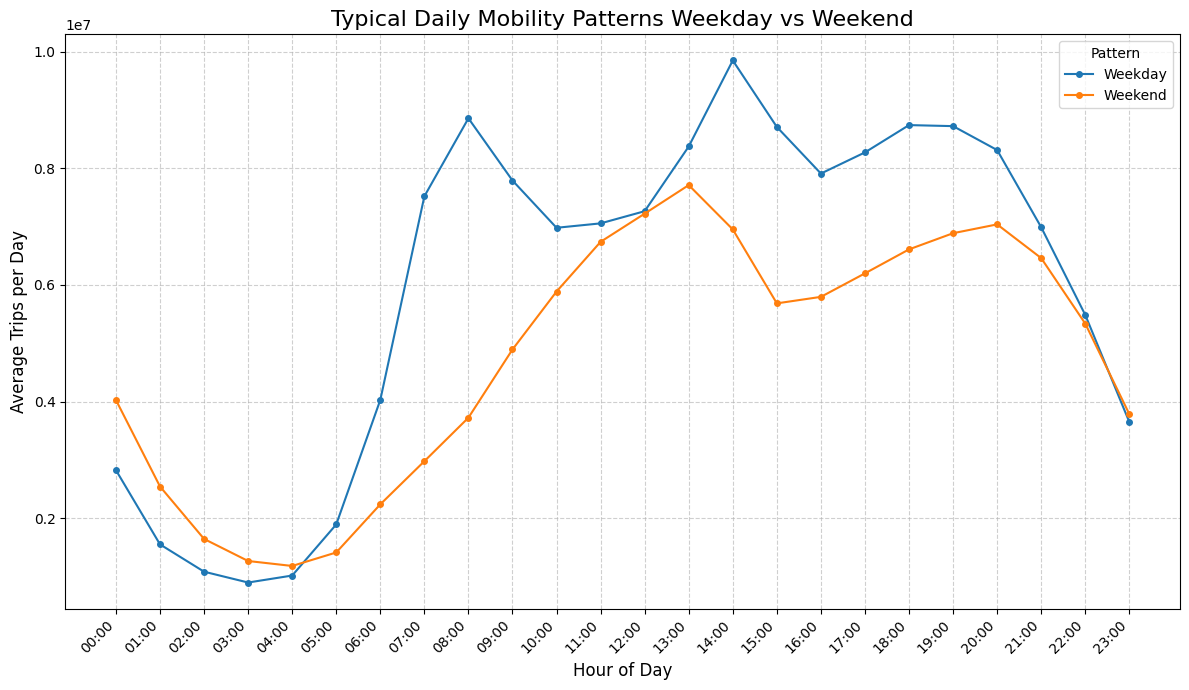

In [25]:
import matplotlib.pyplot as plt

# --- Query the data for plotting ---
print("Querying typical day demand data...")
query = """
SELECT 
    *
FROM gold.daily_average_trips
"""
demand_df = con.execute(query).df()



if demand_df.empty:
    print("ERROR: 'gold.typical_day_demand' table is empty. No data to plot.")
else:
    # --- Prepare data for plotting ---
    print("Pivoting data for plotting...")
    pivot_df = demand_df.pivot(index='hour', columns='day_type', values='average_hourly_trips')
    
    # --- Create the plot ---
    print("Generating plot with matplotlib...")
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot the data
    pivot_df.plot(kind='line', ax=ax, marker='o', markersize=4)
    
    ax.set_title('Typical Daily Mobility Patterns Weekday vs Weekend', fontsize=16)
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Average Trips per Day', fontsize=12)
    
    # Set x-ticks to be clear
    ax.set_xticks(range(0, 24))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add legend
    ax.legend(title='Pattern')
    
    # Ensure labels are not cut off
    plt.tight_layout()
    
    
    # Display the plot in the notebook
    plt.show()

In [26]:
# --- Step 1: Create the new Gold VIEW (using silver_zone_metrics) ---
# This view aggregates trips first, then joins them to the rent/population
# data which we will source directly from the 'silver_zone_metrics' view.

print("Creating Gold view: 'gold.zone_summary_by_rent'...")

# We are ADDING a WHERE clause to trips_originating and trips_destination
query_create_view = """--sql
CREATE OR REPLACE VIEW gold.zone_summary_by_rent AS (
    
    -- Step 1: Create our dimension of unique zones using silver_zone_metrics
    WITH dim_zones_rent AS (
        SELECT DISTINCT
            origin_zone_id AS mitma_zone_id,
            origin_population AS population_count,
            origin_avg_rent_eur
        FROM silver.silver_zone_metrics
        WHERE origin_zone_id IS NOT NULL
    ),
    
    -- Step 2: Bucket the zones into 4 rent "tiers" (quartiles)
    zones_with_tiers AS (
        SELECT
            *,
            NTILE(4) OVER (ORDER BY origin_avg_rent_eur) AS rent_tier
        FROM dim_zones_rent
        WHERE origin_avg_rent_eur IS NOT NULL 
    ),
    
    zones_with_labels AS (
        SELECT
            *,
            CASE rent_tier
                WHEN 1 THEN '1_Low'
                WHEN 2 THEN '2_Medium'
                WHEN 3 THEN '3_High'
                WHEN 4 THEN '4_VeryHigh'
            END AS rent_category
        FROM zones_with_tiers
    ),
    
    -- Step 3: Aggregate trips by ORIGIN (excluding intra-zone)
    trips_originating AS (
        SELECT
            origin_zone_id,
            SUM(trips_count) AS total_trips_originating
        FROM silver.silver_integrated_od
        WHERE origin_zone_id != destination_zone_id 
        GROUP BY 1
    ),
    
    -- Step 4: Aggregate trips by DESTINATION (excluding intra-zone)
    trips_destination AS (
        SELECT
            destination_zone_id,
            SUM(trips_count) AS total_trips_destination
        FROM silver.silver_integrated_od
        WHERE origin_zone_id != destination_zone_id 
        GROUP BY 1
    )
    
    -- Step 5: Join the small, pre-aggregated tables together
    SELECT
        z.mitma_zone_id,
        z.rent_category,
        z.origin_avg_rent_eur AS avg_net_rent_eur,
        z.population_count,
        COALEscE(to_trip.total_trips_originating, 0) AS total_trips_originating,
        COALEscE(from_trip.total_trips_destination, 0) AS total_trips_destination
    FROM zones_with_labels AS z
    LEFT JOIN trips_originating AS to_trip
        ON z.mitma_zone_id = to_trip.origin_zone_id
    LEFT JOIN trips_destination AS from_trip
        ON z.mitma_zone_id = from_trip.destination_zone_id
);
"""

# Execute the CREATE VIEW command (this will be instant)
con.execute(query_create_view)
print("✓ View 'gold.zone_summary_by_rent' updated successfully (intra-zone trips excluded).")

Creating Gold view: 'gold.zone_summary_by_rent'...
✓ View 'gold.zone_summary_by_rent' updated successfully (intra-zone trips excluded).


In [27]:
# --- Step 2: Query the new view ---


print("\n--- Summary of Trips and Rent by Zone (Sample) ---")
query_select = """--sql
SELECT * FROM gold.zone_summary_by_rent
WHERE total_trips_originating > 0 OR total_trips_destination > 0
ORDER BY avg_net_rent_eur DESC
LIMIT 10;
"""

# Execute the query and display the result
display(con.execute(query_select).df())


--- Summary of Trips and Rent by Zone (Sample) ---


,mitma_zone_id,rent_category,avg_net_rent_eur,population_count,total_trips_originating,total_trips_destination
0,2006902,4_VeryHigh,32257,8659,255359.0,255737.0
1,2811501,4_VeryHigh,32039,50500,1010241.0,1010145.0
2,2807905,4_VeryHigh,32019,145444,2709112.0,2688619.0
3,0801905,4_VeryHigh,31710,147434,2109946.0,2113099.0
4,4802006,4_VeryHigh,30762,51152,1339735.0,1340407.0
5,2807904,4_VeryHigh,29687,145579,2639355.0,2635684.0
6,2807907,4_VeryHigh,29126,138335,2540099.0,2533083.0
7,0820503,4_VeryHigh,28747,8444,168560.0,168190.0
8,0820502,4_VeryHigh,28567,20790,314668.0,316059.0
9,2811502,4_VeryHigh,28212,36634,678605.0,674904.0


Querying and plotting average trips by rent category...


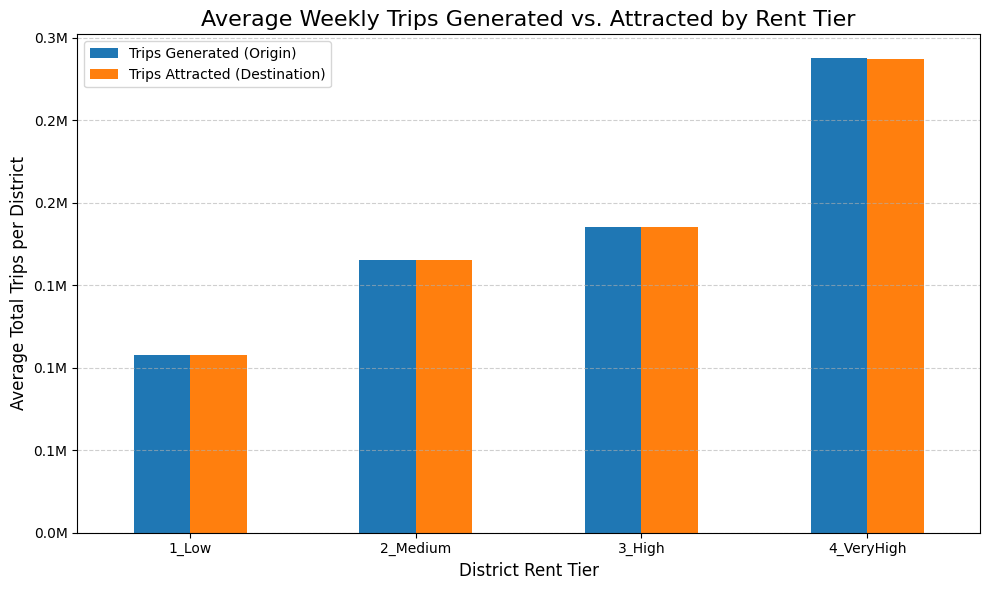

In [28]:
# --- Step 3: Plot the results by Rent Category ---


print("Querying and plotting average trips by rent category...")
query_plot = """--sql
SELECT
    rent_category,
    AVG(total_trips_originating) AS avg_trips_generated,
    AVG(total_trips_destination) AS avg_trips_attracted
FROM gold.zone_summary_by_rent
GROUP BY rent_category
ORDER BY rent_category;
"""
plot_df = con.execute(query_plot).df()

# --- Create the plot ---
if plot_df.empty:
    print("ERROR: No data to plot.")
else:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set the index to the category for easier plotting
    plot_df.set_index('rent_category').plot(
        kind='bar', 
        ax=ax,
        rot=0
    )
    
    ax.set_title('Average Weekly Trips Generated vs. Attracted by Rent Tier', fontsize=16)
    ax.set_xlabel('District Rent Tier', fontsize=12)
    ax.set_ylabel('Average Total Trips per District', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6, axis='y')
    ax.legend(['Trips Generated (Origin)', 'Trips Attracted (Destination)'])
    
    # Format Y-axis to be more readable (e.g., "1.0M" for millions)
    from matplotlib.ticker import FuncFormatter
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

    plt.tight_layout()
    plt.show()

### gold_infrastructure_gaps

In [29]:
print("Creating Gold table 'gold_infrastructure_gaps'...")

# Esta consulta responde a la Pregunta de Negocio 2
gold_bq2_query = """--sql
CREATE OR REPLACE TABLE gold.gold_infrastructure_gaps AS

WITH model_calculation AS (
    SELECT
        origin_zone_id,
        destination_zone_id,
        origin_population,                     -- P_i
        destination_avg_rent_eur,              -- E_j
        total_actual_trips,                    -- Viajes reales
        
        -- Calcular distancia (d_ij) en KM usando la extensión espacial
        -- Usamos GREATEST(0.5, ...) para evitar distancias de 0 (ej. viajes en la misma zona)
        -- y así prevenir errores de división por cero.
        GREATEST(
            0.5, -- Distancia mínima de 0.5 km
            st_distance_spheroid(
                st_point(origin_longitude, origin_latitude), 
                st_point(destination_longitude, destination_latitude)
            ) / 1000 -- Convertir metros (salida de st_distance) a KM
        ) AS geographic_distance_km             -- d_ij
            
    FROM silver.silver_zone_metrics
    
    -- Filtramos datos malos para evitar errores en el modelo
    WHERE origin_population > 0 
      AND destination_avg_rent_eur > 0
      AND origin_latitude IS NOT NULL
      AND destination_latitude IS NOT NULL
      AND SUBSTR(origin_zone_id, 1, 5) != SUBSTR(destination_zone_id, 1, 5) -- Evitar viajes dentro de la misma zona
)

-- Calcular el modelo final y el mismatch
SELECT
    origin_zone_id,
    destination_zone_id,
    total_actual_trips,
    origin_population,
    destination_avg_rent_eur,
    geographic_distance_km,
    
    -- Calcular Modelo de Gravedad T_ij = k * (P_i * E_j) / (d_ij^2)
    -- Asumimos k=1 para este PoC del Sprint 1
    (1.0 * (CAST(origin_population AS DOUBLE) * CAST(destination_avg_rent_eur AS DOUBLE))) / 
    (geographic_distance_km * geographic_distance_km) AS estimated_potential_trips, -- T_ij
        
    -- Calcular Mismatch Ratio 
    -- (Viajes Reales / Viajes Estimados)
    total_actual_trips / NULLIF(estimated_potential_trips, 0) AS mismatch_ratio

FROM model_calculation;
"""

con.execute(gold_bq2_query)
print("✓ Tabla 'gold.gold_infrastructure_gaps' creada.")

# --- Verificación ---
print("\n--- Verificación BQ2: Top 10 Zonas con 'Mismatch' (potencialmente peor servidas) ---")
verification_bq2 = """
    SELECT 
        origin_zone_id,
        destination_zone_id,
        total_actual_trips,
        estimated_potential_trips,
        geographic_distance_km,
        mismatch_ratio
    FROM gold.gold_infrastructure_gaps
    WHERE total_actual_trips > 10 -- Filtrar pares con muy pocos viajes
    AND origin_zone_id != destination_zone_id -- Evitar viajes dentro de la misma zona
    ORDER BY mismatch_ratio ASC -- Ordenamos por ratio más bajo (peor servicio)
    LIMIT 10;
"""
display(con.execute(verification_bq2).df())

Creating Gold table 'gold_infrastructure_gaps'...
✓ Tabla 'gold.gold_infrastructure_gaps' creada.

--- Verificación BQ2: Top 10 Zonas con 'Mismatch' (potencialmente peor servidas) ---


,origin_zone_id,destination_zone_id,total_actual_trips,estimated_potential_trips,geographic_distance_km,mismatch_ratio
0,0827905,08905,11.0,2.920442e+06,17.415651,0.000004
1,4801309,4808402,207.0,4.591171e+07,2.003420,0.000005
2,4801303,4808402,129.0,2.799806e+07,2.003420,0.000005
3,08105,0812506,115.0,2.021890e+07,3.044668,0.000006
4,0808902,0826302,12.0,1.915287e+06,9.979997,0.000006
5,4808402,4801303,150.0,2.341748e+07,2.003420,0.000006
6,0827906,08905,17.0,2.647546e+06,17.415651,0.000006
7,0808902,08905,11.0,1.640105e+06,12.874692,0.000007
8,0827903,08905,11.0,1.625476e+06,17.415651,0.000007
9,4807802,4808402,246.0,3.616035e+07,1.983159,0.000007


In [30]:
print("\n--- Verificación BQ2: Top 10 Zonas con 'Mismatch' (potencialmente peor servidas) ---")
verification_bq2 = """
    SELECT 
        origin_zone_id,
        destination_zone_id,
        total_actual_trips,
        estimated_potential_trips,
        geographic_distance_km,
        mismatch_ratio
    FROM gold.gold_infrastructure_gaps
    WHERE total_actual_trips > 10 -- Filtrar pares con muy pocos viajes
    ORDER BY mismatch_ratio ASC -- Ordenamos por ratio más bajo (peor servicio)
    LIMIT 15;
"""
display(con.execute(verification_bq2).df())


--- Verificación BQ2: Top 10 Zonas con 'Mismatch' (potencialmente peor servidas) ---


,origin_zone_id,destination_zone_id,total_actual_trips,estimated_potential_trips,geographic_distance_km,mismatch_ratio
0,0827905,08905,11.0,2.920442e+06,17.415651,0.000004
1,4801309,4808402,207.0,4.591171e+07,2.003420,0.000005
2,4801303,4808402,129.0,2.799806e+07,2.003420,0.000005
3,08105,0812506,115.0,2.021890e+07,3.044668,0.000006
4,0808902,0826302,12.0,1.915287e+06,9.979997,0.000006
5,4808402,4801303,150.0,2.341748e+07,2.003420,0.000006
6,0827906,08905,17.0,2.647546e+06,17.415651,0.000006
7,0808902,08905,11.0,1.640105e+06,12.874692,0.000007
8,0827903,08905,11.0,1.625476e+06,17.415651,0.000007
9,4807802,4808402,246.0,3.616035e+07,1.983159,0.000007


In [31]:
con.close()